In [49]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns

import matplotlib.pyplot as plt


from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import t
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from scipy.stats import probplot

from statsmodels.nonparametric.kde import KDEUnivariate
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from tensorflow import keras
#from tensorflow.keras.utils import plot_model


######################################
#from pmdarima import auto_arima
#from diptest import diptest

In [50]:
class prediction_analysis:

    def __init__(self, df, y_pred, npast, nfuture):
        self.df = df
        self.y_pred = y_pred
        self.npast = npast
        self.nfuture = nfuture


    def plot_predictions(self):
        df_plot = self.df.iloc[self.npast:].copy()
        df_plot['Predicted_Close'] = self.y_pred

        # Calculate percentage error
        df_plot['Prediction_Change_%'] = 100 * (df_plot['Close'] - df_plot['Predicted_Close']) / df_plot['Close']
        df_plot.dropna(inplace=True)

        fig, axs = plt.subplots(4, 1, figsize=(12, 10))
        fig.subplots_adjust(hspace=0.5)

        # --- Subplot 1: Time Series ---
        axs[0].plot(df_plot.index, df_plot['Close'], label='Actual Close', color='blue')
        axs[0].plot(df_plot.index, df_plot['Predicted_Close'], label='Predicted Close', linestyle='--', color='orange')

        split_time = self.df.iloc[-self.nfuture].name
        axs[0].axvline(x=split_time, color='black', linestyle=':', label='Train/Test Split')

        axs[0].set_title('Actual vs Predicted Close Prices')
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Price')
        axs[0].legend()
        axs[0].grid(True)
        axs[0].set_xlim(self.df.index[-2 * self.nfuture], self.df.index[-1] )

        # --- Subplot 2: % Error vs Actual Price ---
        axs[1].scatter(df_plot.index, df_plot['Prediction_Change_%'], alpha=0.6, color='green')
        axs[1].axhline(y=0, color='red', linestyle='--', label='No Error')
        split_time = self.df.iloc[-self.nfuture].name
        axs[1].axvline(x=split_time, color='black', linestyle=':', label='Train/Test Split')

        axs[1].set_title('Percentage Prediction Error vs Actual Price')
        axs[1].set_xlabel('Date')
        axs[1].set_ylabel('Prediction_Change_%')
        axs[1].legend()
        axs[1].grid(True)
        axs[1].set_ylim(-20, 20)

    #subplot 3
        test_preds = df_plot.iloc[-self.nfuture:]['Prediction_Change_%'].values

        # Fit a Student's t-distribution to the data
        df_t, loc_t, scale_t = t.fit(test_preds)

        # Compute statistics from t-distribution
        mean_pred = loc_t
        std_pred = scale_t * np.sqrt(df_t / (df_t - 2)) if df_t > 2 else np.inf
        ci_lower, ci_upper = t.interval(0.95, df_t, loc=loc_t, scale=scale_t)

        # Plot histogram with KDE
        sns.histplot(test_preds, kde=True, bins=50, color='skyblue', edgecolor='black', ax=axs[2])

        # Plot mean
        axs[2].axvline(mean_pred, color='red', linestyle='-', label=f'Mean (t-fit): {mean_pred:.2f}')

        # Plot ±1σ range
        axs[2].axvline(mean_pred - std_pred, color='purple', linestyle='--', label=f'-1σ: {mean_pred - std_pred:.2f}')
        axs[2].axvline(mean_pred + std_pred, color='purple', linestyle='--', label=f'+1σ: {mean_pred + std_pred:.2f}')

        # Plot 95% confidence interval (CI)
        axs[2].axvspan(ci_lower, ci_upper, color='gray', alpha=0.3, label=f'95% CI (t-fit): {ci_lower:.2f} - {ci_upper:.2f}')

        # Plot formatting
        axs[2].set_title('Histogram of Prediction_Change_% (Test Set) with T-Distribution Fit')
        axs[2].set_xlabel('Prediction_Change_%')
        axs[2].set_ylabel('Frequency')
        axs[2].legend()
        axs[2].grid(True)
        axs[2].set_xlim(mean_pred - 4 * std_pred, mean_pred + 4 * std_pred)

        # --- Subplot 4: Bimodal Distribution with Gaussian Mixture Model ---
        gmm = GaussianMixture(n_components=2, random_state=42)
        gmm.fit(test_preds.reshape(-1, 1))
        labels = gmm.predict(test_preds.reshape(-1, 1))

        # Extract means and variances of both components
        means = gmm.means_.flatten()
        variances = gmm.covariances_.flatten()

        sns.histplot(test_preds, bins=30, kde=True, color="gray", alpha=0.5, ax=axs[3])
        axs[3].scatter(test_preds, [-0.01]*len(test_preds), c=labels, cmap="coolwarm", s=5)
        axs[3].set_title(f"GMM Fit: Mean1={means[0]:.2f}, Var1={variances[0]:.2f} | Mean2={means[1]:.2f}, Var2={variances[1]:.2f}")


        prediction = self.y_pred[-1]
        mean=df_plot['Prediction_Change_%'].mean()
        std=df_plot['Prediction_Change_%'].std()
        ci_lower, ci_upper = t.interval(0.95, df_t, loc=loc_t, scale=scale_t)

        # Corrected prediction
        corrected = prediction * (1 + mean / 100)

        # 95% CI bounds
        ci_low = prediction * (1 + ci_lower / 100)
        ci_high = prediction * (1 + ci_upper / 100)

        # Print results
        print("Actual + 1 year:" , self.df.iloc[-1, 0])
        print(f"Prediction + 1 year: {prediction:.2f}")
        print(f"Corrected Prediction: {corrected:.2f}")
        print(f"95% Confidence Interval: [{ci_low:.2f}, {ci_high:.2f}]")
        print(f"±1 Standard Deviation Range: [{prediction * (1 + (mean - std)/100):.2f}, {prediction * (1 + (mean + std)/100):.2f}]")



In [51]:
class SARIMAModel:
    def __init__(self, df ,order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
        self.df = df
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None

    def train(self, data):
        self.model = SARIMAX(data, order=self.order, seasonal_order=self.seasonal_order).fit()

    def predict(self, steps):
        return self.model.forecast(steps=steps)


In [52]:
class LSTMModel:
    def __init__(self, sequence_length):

        # Define model architecture
        inputs = keras.Input(shape=(sequence_length, 1 ))
        x = keras.layers.LSTM(252, return_sequences=True)(inputs)
        x = keras.layers.Dropout(0.3)(x)
        x = keras.layers.LSTM(252, return_sequences=True)(x)
        x = keras.layers.Dropout(0.3)(x)
        x = keras.layers.LSTM(252)(x)
        outputs = keras.layers.Dense(1, activation='relu')(x)

        # Compile model
        self.model = keras.Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer='adam', loss="mse")
        self.model.summary()

    def train(self, X_train, y_train, epochs=25, batch_size=32):
        x_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        self.model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split = 0.2)

    def predict(self, x_test):
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        return self.model.predict(x_test)

In [53]:
class RandomForestModel:
    def __init__(self):
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)

    def train(self, x_train, y_train):
        self.model.fit(x_train, y_train)

    def predict(self, x_test):
        return self.model.predict(x_test)

In [54]:
class RidgeModel:
    def __init__(self):
        self.model = Ridge()

    def train(self, x_train, y_train):
        self.model.fit(x_train, y_train)

    def predict(self, x_test):
        return self.model.predict(x_test)

In [55]:
class NoiseGenerator:
    def __init__(self, noise_type='gaussian', mu=0.0, sigma=1.0, s0=0, dt=1, seed=42):
        self.noise_type = noise_type
        self.mu = mu
        self.sigma = sigma
        self.s0 = s0
        self.dt = dt
        np.random.seed(seed)  # For reproducibility
        self.n = None

    def generate(self, n):
        self.n=n

        if self.noise_type == 'gaussian':
            return self._gaussian()
        elif self.noise_type == 'brownian':
            return self._brownian()
        elif self.noise_type == 'exponential_brownian':
            return self._exponential_brownian()
        else:
            raise ValueError("Invalid noise type. Choose from 'gaussian', 'brownian', or 'exponential_brownian'.")

    def _gaussian(self):
        """Generates Gaussian (normal) noise."""
        return np.random.normal(self.mu, self.sigma, self.n)

    def _brownian(self):
        """Generates Brownian motion (Wiener process)."""
        w = np.random.normal(self.mu, np.sqrt(self.dt), self.n).cumsum()
        return self.s0 + self.mu * np.arange(self.n) * self.dt + self.sigma * w

    def _exponential_brownian(self):
        """Generates Exponential Brownian Motion (Geometric Brownian Motion)."""
        w = np.random.normal(0, np.sqrt(self.dt), self.n).cumsum()
        time = np.linspace(0, self.n * self.dt, self.n)
        return self.s0 * np.exp((self.mu - 0.5 * self.sigma**2) * time + self.sigma * w)

In [56]:
class StockData:
    def __init__(self, ticker, start, end, column):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.df = None
        self.column=column

    def fetch_data(self):
        self.df = yf.download(self.ticker, start=self.start, end=self.end)

        self.df = self.df.sort_index()
        self.df = self.df.dropna()
        self.df.info()

        #PLOT
        ax = self.df.drop(columns=["Volume"]).plot(figsize=(12, 6), title=self.ticker + "Stock Prices")
        ax.set_ylabel("Stock Price")
        ax2 = ax.twinx()
        ax2.set_ylabel("Volume")
        ax2.plot(self.df.index, self.df["Volume"], color="gray", alpha=0.5, linestyle="dashed", label="Volume")
        ax2.legend(loc="upper left")
        plt.show()

        self.df.columns = self.df.columns.get_level_values(0)
        new_df = self.df[[self.column]].copy()
        new_df.info()

        return new_df

In [57]:
class features_ml:

    def __init__(self, df, noise_generator, npast, column, param = 252, split_type='index'):
        self.df = df.copy()
        self.noise_generator = noise_generator
        self.npast = npast
        self.split_type = split_type
        self.param = param
        self.column=column
        self.X=None
        self.Y=None

    def features(self):
        self.df["date"] = self.df.index
        self.df["year"] = self.df["date"].dt.year
        self.df["month"] = self.df["date"].dt.month
        #self.df["day"] = self.df["date"].dt.day
        #self.df['day_of_year'] = self.df["date"].dt.dayofyear
        self.df.drop(columns=["date"], inplace=True)

        self.df['Noise'] = self.noise_generator.generate(self.df.shape[0])

        for lag in range(1, self.npast + 1):
            self.df[f'lag{lag}'] = self.df[self.column].shift(lag)

        self.df.dropna(inplace=True)

        self.y = self.df[self.column].copy()
        self.X = self.df.drop(columns=self.column).copy()
        self.X.info()
        return self.X, self.y

In [58]:
class FutureDataPoint:
    def __init__(self, X_train_last, y_train_pred_npast , model, scaler, npast, noise_generator, column):
        self.X_new = X_train_last.copy()
        self.y_train_pred_npast = y_train_pred_npast.copy()
        self.model = model
        self.scaler = scaler
        self.npast = npast
        self.noise_generator = noise_generator
        self.column = column

    def predict_future_steps(self, nfuture):
        y_test_pred = []
        for i in range(nfuture):

            next_index = self.X_new.index[0] + pd.tseries.offsets.BDay(1) # Set the next business day as the index
            self.X_new.index = [next_index]

            y_next = self.generate_datapoint_predict()
            y_test_pred.append(y_next)

        return np.array(y_test_pred)

    def generate_datapoint_predict(self):
        self.X_new["date"] = self.X_new.index
        self.X_new["year"] = self.X_new["date"].dt.year
        self.X_new["month"] = self.X_new["date"].dt.month
        #self.X_new["day"] = self.X_new["date"].dt.day
        #self.X_new["day_of_year"] = self.X_new["date"].dt.dayofyear
        self.X_new.drop(columns=["date"], inplace=True)

        # Add noise to the dataset
        self.X_new['Noise'] = self.noise_generator.generate(1)

        #add lags from predictions
        for i in range(1, self.npast+1):
            self.X_new[f'lag{i}'] = self.y_train_pred_npast[-i]
        self.X_new.dropna(inplace=True)

        # Scale the new data point
        X_new_scaled = self.scaler.transform(self.X_new)

        # Predict next value
        y_next = self.model.predict(X_new_scaled)

        for i in range(0,self.npast-1):
          self.y_train_pred_npast[i+1] = self.y_train_pred_npast[i]
        self.y_train_pred_npast[0] = y_next.flatten()[0]

        return y_next

[*********************100%***********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4299 entries, 2007-09-17 to 2025-03-28
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^NSEI)   4299 non-null   float64
 1   (High, ^NSEI)    4299 non-null   float64
 2   (Low, ^NSEI)     4299 non-null   float64
 3   (Open, ^NSEI)    4299 non-null   float64
 4   (Volume, ^NSEI)  4299 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 201.5 KB


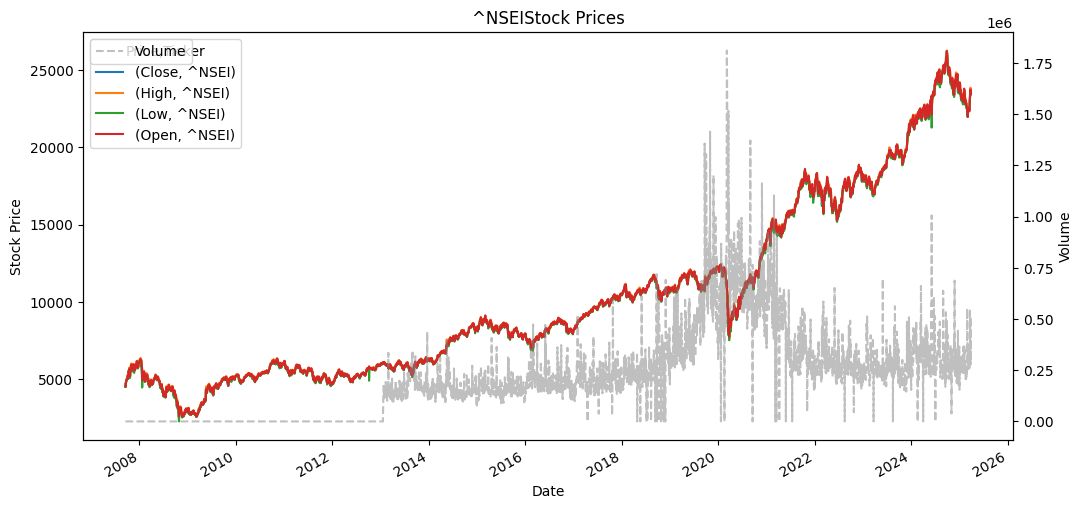

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4299 entries, 2007-09-17 to 2025-03-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4299 non-null   float64
dtypes: float64(1)
memory usage: 67.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4297 entries, 2007-09-19 to 2025-03-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    4297 non-null   int32  
 1   month   4297 non-null   int32  
 2   Noise   4297 non-null   float64
 3   lag1    4297 non-null   float64
 4   lag2    4297 non-null   float64
dtypes: float64(3), int32(2)
memory usage: 167.9 KB
Actual + 1 year: 23519.349609375
Prediction + 1 year: 18778.31
Corrected Prediction: 18966.01
95% Confidence Interval: [19688.17, 25135.17]
±1 Standard Deviation Range: [18099.02, 19832.99]


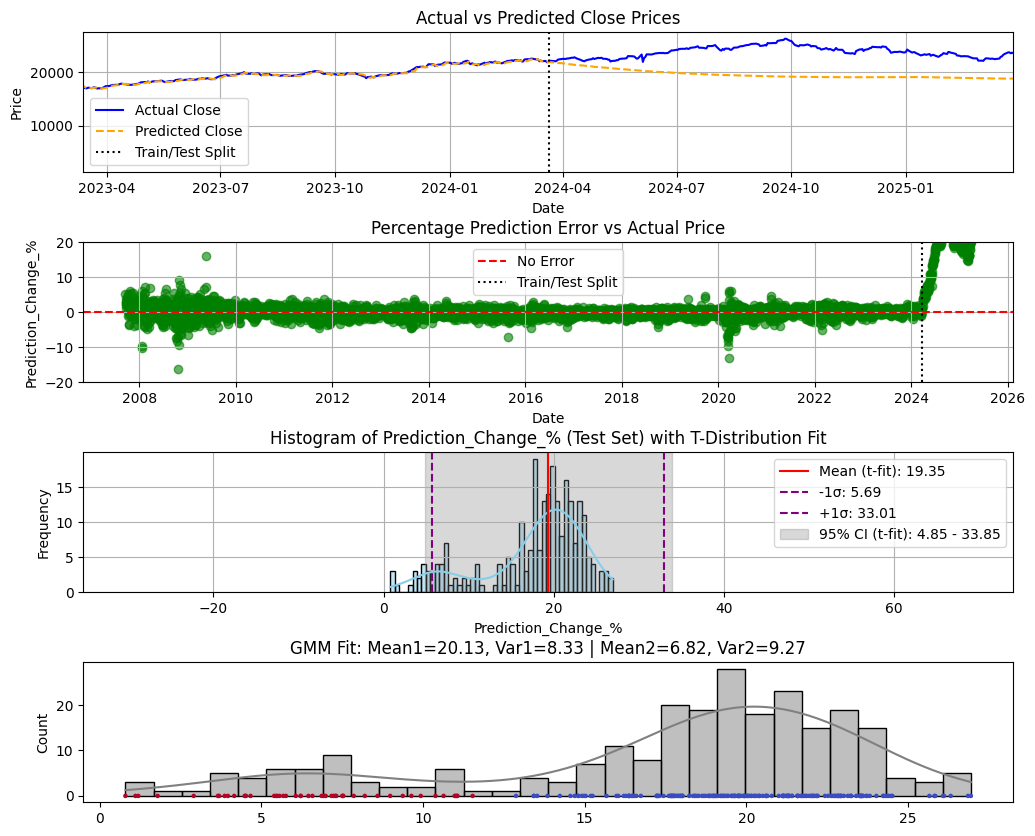

In [59]:
class StockPredictor:
    def __init__(self, ticker, start, end, column ,noise_generator, npast = 10, nfuture = 252, model_type='Ridge'):

        self.ticker = ticker
        self.start = start
        self.end = end
        self.model_type = model_type
        self.df=None
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.npast = npast
        self.nfuture = nfuture
        self.noise_generator = noise_generator
        self.column=column

        if model_type == 'Ridge':
            self.model = RidgeModel()
        elif model_type == 'RandomForest':
            self.model = RandomForestModel()
        elif model_type == 'LSTM':
            self.model = LSTMModel(sequence_length=self.npast + 3)
        elif model_type == 'SARIMA':
            self.model = SARIMAModel()
        else:
            raise ValueError("Unsupported model type")

    def run(self):

        self.df = StockData(self.ticker, self.start, self.end, self.column).fetch_data()

        if self.model_type == 'SARIMA':
            self.model.train(self.df.flatten())
            predictions = self.model.predict(y_test, self.noise_generator)
        else:
            X, y = features_ml(self.df, self.noise_generator, self.npast, self.column, param = self.nfuture, split_type='index').features()

            split_index = int(X.shape[0] - self.nfuture)

            X_train, X_test = X[:split_index], X[split_index:]
            y_train, y_test = y[:split_index], y[split_index:]

            X_train_scaled = self.scaler.fit_transform(X_train)
            self.model.train(X_train_scaled, y_train)

            y_train_pred = self.model.predict(X_train_scaled)
            y_test_pred = FutureDataPoint(X_train.iloc[[-1]], y_train_pred[-self.npast:] , self.model, self.scaler, self.npast, self.noise_generator, self.column).predict_future_steps(self.nfuture)

        y_pred=np.concatenate((y_train_pred.flatten(), y_test_pred.flatten()))

        prediction_analysis(self.df, y_pred, self.npast, self.nfuture).plot_predictions()

noise_generator = NoiseGenerator(noise_type='gaussian', mu=0, sigma=1, s0=0, dt=1)
predictor = StockPredictor('^NSEI', '2000-01-01', date.today(), 'Close', noise_generator, npast = 2, nfuture = 252, model_type='Ridge')
predictor.run()